In [1]:
import glob
import lasio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
from colorsys import hsv_to_rgb
from random import randint, uniform
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

%matplotlib inline

In [38]:
wells = glob.glob(r'E:\UT Austin\Datasets\LAS_files\mannville_demo_data\*.las')

In [90]:
uwi =[]
datum = []
ground = []
eref = []
units = []
failure = 0
for well in wells:
    curve = lasio.read(well)
    try:
        #if curve.params['GL'].unit == 'M' and (curve.curves['DEPT'].unit !='F' or curve.curves['DEPTH'].unit != 'F'):
        da = curve.params['DATM'].value
        gl = curve.params['GL'].value
        u = curve.well['UWI'].value
        units.append(curve.params['GL'].unit)
        eref.append(curve.params['EREF'].value)
        uwi.append(u)
        datum.append(da)
        ground.append(gl)
    except:
        print('failure')
        failure +=1
print(failure)

In [2]:
well_dict = pd.read_csv(r'mann_well_dict.csv')

In [48]:
dataframe = pd.DataFrame({"UWI":uwi, "DATUM":datum, "GL":ground, 'EREF':eref, 'UNIT':units})
#dataframe.to_csv('mann_dirty_LAS.csv')

NameError: name 'uwi' is not defined

In [3]:
dataframe = pd.read_csv('mann_dirty_LAS.csv')
new_df = pd.merge(dataframe, well_dict,  how='left', left_on=['UWI'], right_on = ['UWI'])

In [4]:
new_df.dropna(inplace=True)

In [5]:
tops = pd.read_csv(r"mannvillegrp_picks.csv") #read in the top data
tops.rename(columns={'Pick':'MD'}, inplace=True)

In [6]:
new_df = pd.merge(tops, new_df,  how='left', left_on=['SitID'], right_on = ['SitID'])

not_nullDF = new_df.loc[new_df['UWI'].notnull()]

not_nullDF['TVDSS'] = (not_nullDF.datum-not_nullDF.MD).values

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
tops = not_nullDF

In [27]:
not_nullDF.to_csv('mannville_cleaned.csv')

# Below are the predictions, above is cleaning

In [2]:
tops = pd.read_csv(r"mannville_cleaned.csv", index_col=[0]) #read in the top data
#tops.rename(columns={'TVDSS':'SS'}, inplace=True)
print(tops.shape)
#tops[tops.SitID.isin([108715, 108736, 113822])].index.values
#tops.drop(tops[tops.SitID.isin([108715, 108736, 113822])].index.values, inplace=True)
#print(tops.shape)

(19734, 12)


In [3]:
#tops.drop(tops[tops.SitID==123627].index.values, inplace=True)
ssmin = tops.TVDSS.min()
#tops.TVDSS = tops.TVDSS - ssmin #standardize the subsea values

tops.dropna(inplace=True)
ssmin

-671.85

In [42]:
tops = tops[tops.Quality >=0]

In [43]:
tops.SitID.value_counts().describe()

count    2122.000000
mean        9.299717
std         2.097053
min         1.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        12.000000
Name: SitID, dtype: float64

In [44]:
#tops.drop(['MD', 'GL', 'DELEV', 'DT'], axis=1, inplace=True)
def sample_splitter(dataframe, fraction, randomseed):
    test = dataframe.sample(frac=fraction, random_state=randomseed)
    test_idx = test.index.values
    train =  dataframe.drop(test_idx)
    return train, test
train, test = sample_splitter(tops, 0.1, 86)

print(f'Training size is {len(train)} tops, and test size is {len(test)} tops')

D_df = train.pivot_table("TVDSS", "Formation", "SitID").fillna(0)#pivot table to move into sparse matrix land
R = D_df.values
A = binarize(R) 

Training size is 17761 tops, and test size is 1973 tops


In [45]:
print(f'{round(((D_df == 0).astype(int).sum().sum())/((D_df == 0).astype(int).sum().sum()+(D_df != 0).astype(int).sum().sum()),3)*100} percent of the tops are missing')

40.2 percent of the tops are missing


In [46]:
print(f'There are {len(tops.UWI.unique())} wells and {len(tops.Formation.unique())} tops')

There are 2122 wells and 14 tops


In [47]:
#ALS factorization from 
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    """
    #print("Initiating ")
    lambda_ = lambda_
    n_factors = n_factors
    n, m = A.shape
    n_iterations = n_iterations
    np.random.seed(86)
    Users = 5 * np.random.rand(n, n_factors, )
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MAE_List = []

    print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(
                np.dot(Items, np.dot(np.diag(Ri), Items.T))
                + lambda_ * np.eye(n_factors),
                np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
            ).T
   #     print(
   #         "Error after solving for User Matrix:",
   #         get_error(A, Users, Items, R),
   #     )

        for j, Rj in enumerate(R.T):
            Items[:, j] = np.linalg.solve(
                np.dot(Users.T, np.dot(np.diag(Rj), Users))
                + lambda_ * np.eye(n_factors),
                np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
            )
   #     print(
   #         "Error after solving for Item Matrix:",
   #         get_error(A, Users, Items, R),
   #     )

        MAE_List.append(get_error(A, Users, Items, R))
   #     print("%sth iteration is complete..." % iter)
    
    #print(MAE_List)
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #plt.plot(range(1, len(MAE_List) + 1), MAE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    #plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    #plt.savefig('Python MSE Graph.pdf', format='pdf')
    return Users, Items

In [48]:
U, Vt = runALS(R, A, 6, 110, 0.1)

recommendations = np.dot(U, Vt) #get the recommendations

recsys = pd.DataFrame(
    data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
) #results

newDF = recsys.T
newDF.reset_index(inplace=True)

flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

new_df = pd.merge(test, flat_preds,  how='left', left_on=['SitID','Formation'], right_on = ['SitID','Formation'])

new_df.rename(columns={0:'SS_pred'}, inplace=True)

cleanDF = new_df.dropna()

cleanDF['signed_error'] = (cleanDF['TVDSS'] - cleanDF['SS_pred'])

print(MAE(cleanDF.TVDSS.values, cleanDF.SS_pred.values))
print(np.sqrt(MSE(cleanDF.TVDSS.values, cleanDF.SS_pred.values)))

Starting Iterations
10.998980089403288
27.405022367969053


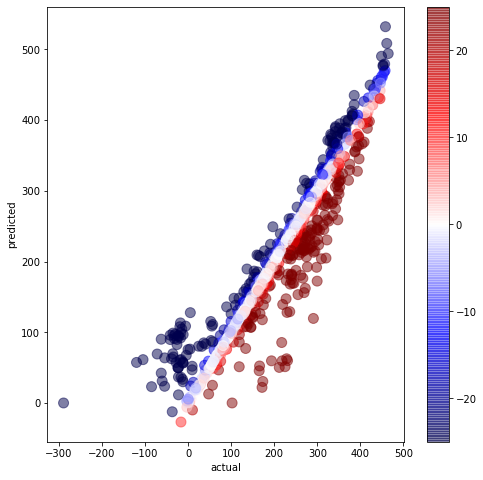

In [49]:
plt.figure(figsize=(8,8))
plt.scatter(cleanDF.TVDSS, cleanDF.SS_pred, c=cleanDF.signed_error, vmin=-25,vmax=25, 
            cmap='seismic', s=100, alpha=0.5)
plt.plot()
plt.xlabel('actual')
plt.ylabel('predicted')
plt.colorbar()

In [50]:
def cross_validation(dataframe, random_seed, latent_vectors, n_iters):
    np.random.seed(random_seed)
    block_1  = dataframe.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops2 = dataframe.drop(block_1)
    block_2 = tops2.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops3 = tops2.drop(block_2)
    block_3 = tops3.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops4 = tops3.drop(block_3)
    block_4 = tops4.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    blocks = [block_1, block_2, block_3, block_4]
    CV_MAE = []
    CV_MSE = []
    for block in blocks:
        validate = dataframe.loc[block]
        main_group = dataframe.drop(block)
        print(f'Validating on {block.shape[0]} tops')
        D_df = main_group.pivot_table("TVDSS", "Formation", "SitID").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        A = binarize(R) 

        
        U, Vt = runALS(R, A, latent_vectors, n_iters, 0.1)

        recommendations = np.dot(U, Vt) #get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(validate, flat_preds,  how='left', left_on=['SitID','Formation'], right_on = ['SitID','Formation'])

        new_df.rename(columns={0:'SS_pred'}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF['signed_error'] = (cleanDF['TVDSS'] - cleanDF['SS_pred'])

        CV_MAE.append(MAE(cleanDF.TVDSS.values-ssmin, cleanDF.SS_pred.values-ssmin))
        CV_MSE.append(np.sqrt(MSE(cleanDF.TVDSS.values-ssmin, cleanDF.SS_pred.values-ssmin)))

    return CV_MSE

# Grid Search

In [17]:
%%capture
grid_search = {} 
els = [] 
nsits = [] 
regulars = [] 
for L in range(2,11):
    for n_it in range(100,460,50):
        grid_search[L,n_it] = np.mean(cross_validation(tops, 86, L, n_it))
        els.append(L)
        nsits.append(n_it)
        print(L, n_it)

In [18]:
L, its = min(grid_search, key=grid_search.get)


In [19]:
print(L, its)

3 100


In [51]:
mae = cross_validation(tops, 86, 3, 100)

Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
print(mae, np.mean(mae))

[25.155076255022802, 25.719749058201934, 27.295179480981865, 29.234061434077496] 26.85101655707102


In [53]:
26.85*3.28084

88.090554

# Cross-validation dataset building

In [56]:
def cross_validation(dataframe, random_seed, latent_vectors, n_iters, reg):
    full = []
    block_1  = dataframe.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops2 = dataframe.drop(block_1)
    block_2 = tops2.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops3 = tops2.drop(block_2)
    block_3 = tops3.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops4 = tops3.drop(block_3)
    block_4 = tops4.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    blocks = [block_1, block_2, block_3, block_4]
    CV_MAE = []
    bk = 1
    for block in blocks:
        print(f'Starting Block {bk}')
        validate = dataframe.loc[block]
        main_group = dataframe.drop(block)
        print(f'Validating on {block.shape[0]} tops')
        D_df = main_group.pivot_table("TVDSS", "Formation", "SitID").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        A = binarize(R) 

        
        U, Vt = runALS(R, A, latent_vectors, n_iters, reg)

        recommendations = np.dot(U, Vt) #get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(validate, flat_preds,  how='left', left_on=['SitID','Formation'], right_on = ['SitID','Formation'])

        new_df.rename(columns={0:'SS_pred'}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF['signed_error'] = (cleanDF['TVDSS'] - cleanDF['SS_pred'])
        cleanDF['Block'] = [bk]*cleanDF.shape[0]
        well_locs = pd.read_csv(r'well_lat_lng.csv')
        #well_locs.rename(columns={'API Number':'API'}, inplace=True)

        full.append(cleanDF.merge(well_locs[['lat', 'lng', 'SitID']], on='SitID'))
        CV_MAE.append(MAE(cleanDF.TVDSS.values-ssmin, cleanDF.SS_pred.values-ssmin))
        bk += 1
    output = pd.concat(full)
    return output

In [57]:
cv_DF = cross_validation(tops, 86, L, its, 0.1)

Starting Block 1
Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting Block 2
Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting Block 3
Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Starting Block 4
Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
strat_order = [1000,2000,3000,4000,5000,6000,7000,8000,9000,9500,10000,11000,12000,13000,14000]

In [62]:
for block in cv_DF['Block'].unique():
    locationDF = cv_DF[cv_DF['Block'] == block]
    mae_errors = []
    n_holdout = []
    formed = []
    colored = []
    stdev = []
    n_train = []
    rms_errors = []
    for formation in strat_order:
        form = locationDF[locationDF['Formation'] == formation]
        if form.TVDSS.values.shape[0] > 0:
            mae_errors.append(round(MAE(form.TVDSS.values-ssmin, form.SS_pred.values-ssmin),1))
            formed.append(formation)
            #colored.append(colors_to_plot[formation])
            stdev.append(np.std(form.signed_error))
            n_holdout.append(form.shape[0])
            n_train.append(tops[tops.Formation == formation].shape[0]-form.shape[0])

            rms_errors.append(np.sqrt(MSE(form.TVDSS.values-ssmin, form.SS_pred.values-ssmin)))
        else:
          #  print(str(formation)+' has no holdout samples'+' n picks='+str(tops[tops.Formation == formation].shape[0]))
            mae_errors.append(np.nan)
            formed.append(formation)
            #colored.append(colors_to_plot[formation])
            stdev.append(np.std(form.signed_error))
            n_train.append(tops[tops.Formation == formation].shape[0]-form.shape[0])
            n_holdout.append(form.shape[0])
            rms_errors.append(np.nan)
    table_1 = pd.DataFrame({'Formation':formed, 'n_train': n_train, 'n_holdout':n_holdout, 'MAE':mae_errors,
                 'RMSE':rms_errors, 'Std':stdev})
    nums = dict(zip(formed, n_holdout))
    errers = dict(zip(formed, mae_errors))
    val = dict(zip(formed, n_holdout))
    #fig, ax = plt.subplots(1,1, figsize=(10,10))

    #for formation in strat_order:
    #        plt.scatter(nums[formation], errers[formation]), #color=colors_to_plot[formation])
    #plt.semilogx()
    #plt.semilogy()
    #plt.xlabel('Number of top picks of each formation', fontsize=6)
    #plt.ylabel('MAE (ft)', fontsize=6)
    #plt.xticks(fontsize=6)
    #plt.yticks(fontsize=6)
    #plt.xlim(0.5, 500)
    #plt.ylim()
    #plt.tight_layout()
    table_1.to_csv('mann_Table_1_block_'+str(block)+'.csv')

In [12]:
color_list = []
for i in range(len(strat_order)):
    if i ==0: #mannville
        h = uniform(23/360, 33/360) # Select random green'ish hue from hue wheel
        s = uniform(0.8, 1)
        v = uniform(0.2, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])
    elif 0<i<=4: #t61 to t31
        h = uniform(83/360, 158/360) 
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 4<i<=5: #clw_wab
        h = uniform(23/360, 33/360) 
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 5<i<= 6: #t21
        h = uniform(83/360, 158/360) 
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 6<i<= 7: #e20
        h = uniform(23/360, 33/360) 
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

    elif 7<i<= 8: #t15
        h = uniform(83/360, 158/360) 
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])
        
    elif 8<i<= 9: #e14
        h = uniform(23/360, 33/360) 
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])
        
    elif 9<i<= 10: #t11
        h = uniform(83/360, 158/360) 
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])
    
    elif 10<i<= 11: #t10.5
        h = uniform(83/360, 158/360) 
        s = uniform(0.8, 1)
        v = uniform(0.3, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])
        
    elif 11<i<= 12: #e10
        h = uniform(23/360, 33/360) 
        s = uniform(0.8, 1)
        v = uniform(0.2, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])
        
    elif 12<i<= 13: #mcmurray
        h = uniform(50/360, 60/360) 
        s = uniform(0.8, 1)
        v = uniform(0.2, 1)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])
        
    else: #PZ
        h = uniform(300/360, 320/360) 
        s = uniform(0.2, 1)
        v = uniform(0.3, 0.5)
        r, g, b = hsv_to_rgb(h, s, v)
        color_list.append([r,g,b])

colors_to_plot = dict(zip(strat_order, color_list))
#pd.DataFrame(colors_to_plot).to_csv('mann_color_palette.csv', index=False)

In [63]:
colors_to_plot =  pd.read_csv('mann_color_palette.csv').to_dict(orient='list')

In [64]:
vc = tops.Formation.value_counts(sort=True)
fm_mapping = {1000:'Mannville Group', 2000:'t61', 3000:'t51', 4000:'t41', 5000:'t31', 6000:'Clearwater/Wabiskaw', 7000:'t21',
              8000:'e20', 9000:'t15', 9500:'e14', 10000:'t11',11000:'t10.5', 12000:'e10', 13000:'McMurray Formation', 
              14000:'Paleozoic'}

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


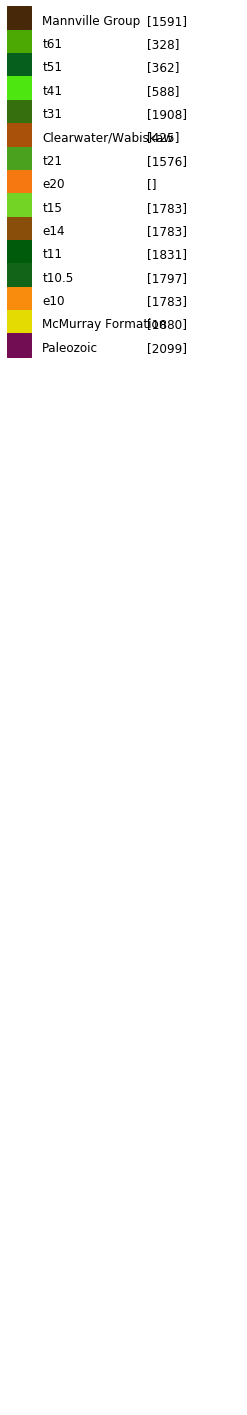

In [118]:
import matplotlib.patches as patches
fig1 = plt.figure(figsize=(20,20))
for i in enumerate(strat_order):
    width = 1
    height = 1
    lims = (0, 10)
    
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.add_patch(
        patches.Rectangle((0, i[0]*-1), width, height, color=colors_to_plot[str(i[1])]))
    ax1.annotate(fm_mapping[i[1]], (1.5, -1*i[0]+0.25), fontsize=12)
    ax1.annotate(vc[vc.index ==i[1]].values,  (6, -1*i[0]+0.25), fontsize=12)
    plt.ylim(-59,1)
    plt.xlim(lims)
plt.tight_layout()
plt.axis('off')
plt.savefig('mann_strat_column.pdf')

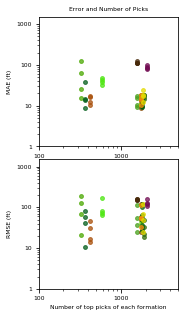

In [121]:
errors = pd.read_csv('mann_errors.csv') #this is output from the folds, compressed in excel 
grid = plt.GridSpec(2, 1, wspace=0.4, hspace=0.1)
fig = plt.figure(figsize=(2.5, 5))

upper = plt.subplot(grid[0, :])

for formation in strat_order:
    subset = errors[errors.Formation == formation]
    upper.scatter(subset['n_holdout']+subset['n_train'], subset['MAE']*3.28084, 
                color=colors_to_plot[str(formation)], alpha=0.75, s=15)
    upper.scatter(subset['n_holdout.1']+subset['n_train.1'], subset['MAE.1']*3.28084,
                color=colors_to_plot[str(formation)], alpha=0.75, s=15)
    upper.scatter(subset['n_holdout.2']+subset['n_train.2'], subset['MAE.2']*3.28084,
                color=colors_to_plot[str(formation)], alpha=0.75, s=15)
    up = upper.scatter(subset['n_holdout.3']+subset['n_train.3'], subset['MAE.3']*3.28084,
                color=colors_to_plot[str(formation)], alpha=0.75, s=15)
upper.semilogx()
upper.semilogy()
#upper.set_xlabel('Number of top picks of each formation', fontsize=6)
upper.set_ylabel('MAE (ft)', fontsize=6)
upper.set_title('Error and Number of Picks', fontsize=6)

upper.set_xticklabels([10**1,10**2, 10**3],fontsize=6,)
upper.set_yticklabels([10^-1,10**0, 10**1, 10**2, 10**3],fontsize=6)#plt.yticks(fontsize=6)
upper.set_xlim(100,5000)
upper.set_ylim(1,1500)


lower = plt.subplot(grid[1, :])

for formation in strat_order:
    subset = errors[errors.Formation == formation]
    lower.scatter(subset['n_holdout']+subset['n_train'], subset['RMSE']*3.28084, 
                color=colors_to_plot[str(formation)], alpha=0.75, s=15)
    lower.scatter(subset['n_holdout.1']+subset['n_train.1'], subset['RMSE.1']*3.28084,
                color=colors_to_plot[str(formation)], alpha=0.75, s=15)
    lower.scatter(subset['n_holdout.2']+subset['n_train.2'], subset['RMSE.2']*3.28084,
                color=colors_to_plot[str(formation)], alpha=0.75, s=15)
    lo = lower.scatter(subset['n_holdout.3']+subset['n_train.3'], subset['RMSE.3']*3.28084,
                color=colors_to_plot[str(formation)], alpha=0.75, s=15)
lower.semilogx()
lower.semilogy()
lower.set_xlabel('Number of top picks of each formation', fontsize=6)
lower.set_ylabel('RMSE (ft)', fontsize=6)
#lower.set_title('Root Mean Squared Error per Formation', fontsize=6)
lower.set_xticklabels([10**1,10**2, 10**3],fontsize=6,)
lower.set_yticklabels([10^-1,10**0, 10**1, 10**2, 10**3],fontsize=6)#plt.yticks(fontsize=6)
lower.set_xlim(100,5000)
lower.set_ylim(1,1500)


plt.savefig('mann_RMSE_formation.pdf')

# Error by well

In [77]:
cv_wells = []
def cross_validation_wells(dataframe, random_seed, latent_vectors, n_iters, reg):
    block_1  = dataframe.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops2 = dataframe.drop(block_1)
    block_2 = tops2.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops3 = tops2.drop(block_2)
    block_3 = tops3.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    tops4 = tops3.drop(block_3)
    block_4 = tops4.sample(n=dataframe.shape[0]//4, random_state=random_seed).index.values
    blocks = [block_1, block_2, block_3, block_4]
    CV_MAE = []
    f = 0
    for block in blocks:
        validate = dataframe.loc[block]
        main_group = dataframe.drop(block)
        print(f'Validating on {block.shape[0]} tops')
        D_df = main_group.pivot_table("TVDSS", "Formation", "SitID").fillna(0)#pivot table to move into sparse matrix land
        R = D_df.values
        A = binarize(R) 

        
        U, Vt = runALS(R, A, latent_vectors, n_iters, reg)

        recommendations = np.dot(U, Vt) #get the recommendations

        recsys = pd.DataFrame(
            data=recommendations[0:, 0:], index=D_df.index, columns=D_df.columns
        ) #results

        newDF = recsys.T
        newDF.reset_index(inplace=True)

        flat_preds = pd.DataFrame(recsys.unstack()).reset_index()

        new_df = pd.merge(validate, flat_preds,  how='left', left_on=['SitID','Formation'], right_on = ['SitID','Formation'])

        new_df.rename(columns={0:'SS_pred'}, inplace=True)

        cleanDF = new_df.dropna()

        cleanDF['signed_error'] = (cleanDF['TVDSS'] - cleanDF['SS_pred'])
        well_locs = pd.read_csv(r'well_lat_lng.csv')
        #well_locs.rename(columns={'API Number':'API'}, inplace=True)

        locationDF = cleanDF.merge(well_locs[['lat', 'lng', 'SitID']], on='SitID')
        aypi = []
        well_mae = []
        well_rmse = []
        east = []
        north = []
        fold = []
        
        print(f'foldno is {f}')
        for well in locationDF.SitID.unique():
            aypi.append(well)
            well_mae.append(locationDF[locationDF.SitID == well].signed_error.abs().mean())
            well_rmse.append(np.sqrt(MSE(locationDF[locationDF.SitID == well].TVDSS,
                                         locationDF[locationDF.SitID == well].SS_pred)))
            east.append(locationDF[locationDF.SitID == well].lng.values[0])
            north.append(locationDF[locationDF.SitID == well].lat.values[0])
            fold.append(f)
        by_wellDF = pd.DataFrame({'SitID':aypi, 'Well_MAE':well_mae, 'well_rmse':well_rmse, 'Longitude':east, 'Latitude':north,
                                 'foldno':fold})
        cv_wells.append(by_wellDF)
        f+=1
        #CV_MAE.append(MAE(cleanDF.SS.values-ssmin, cleanDF.SS_pred.values-ssmin))

    return cv_wells

In [78]:
masterDF = pd.concat(cross_validation_wells(tops, 86, L, its, 0.1))
masterDF.to_csv('mann_error_map.csv')

Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


foldno is 0
Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


foldno is 1
Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


foldno is 2
Validating on 4933 tops
Starting Iterations


C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


foldno is 3


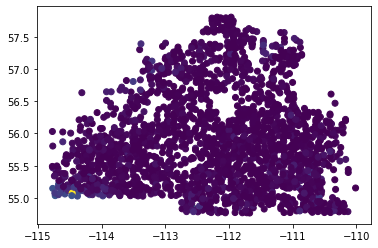

In [79]:
plt.scatter(masterDF[masterDF.foldno == 0].Longitude, masterDF[masterDF.foldno == 0].Latitude, 
            c=masterDF[masterDF.foldno == 0].Well_MAE)

In [80]:
import geopandas as gpd

In [81]:
well_locs = pd.read_csv(r'well_lat_lng.csv')
gdf = gpd.GeoDataFrame(well_locs, geometry=gpd.points_from_xy(well_locs.lng, well_locs.lat))
gdf.crs = {'init':'EPSG:4326'}
reproj = gdf.to_crs({'init':'EPSG:3403'})
reproj['x'] = reproj.geometry.x
reproj['y'] = reproj.geometry.y

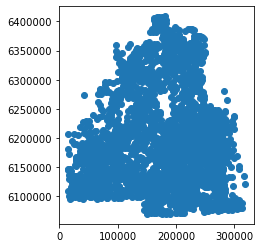

In [82]:
reproj.plot()

# PyVista

In [83]:
import pyvista as pv
import panel
panel.extension("vtk")
pv.set_plot_theme("document")

In [84]:
gl = tops
surface = gl.merge(reproj[['y', 'x', 'SitID']], on='SitID')
cloud = pv.PolyData(np.array(list(zip(surface.x, surface.y, surface.datum))))
surf = cloud.delaunay_2d()

In [85]:
predictions = flat_preds.merge(surface[['y', 'x', 'SitID']], on='SitID')
predictions.drop_duplicates(inplace=True)

In [86]:
plotter = pv.Plotter(notebook=False)
for formation in strat_order:
    subpreds = predictions[predictions['Formation'] == formation]
    points = np.array(list(zip(subpreds.x, subpreds.y, subpreds[0])))
    if points.shape[0] > 0:
        pc = pv.PolyData(points)
    #data = tops_predicted[i][:,-1]
    #pc['elevation'] = data
    plotter.add_points(pc, color=colors_to_plot[str(formation)])#color=[r,g,b])
plotter.add_mesh(surf)
plotter.set_scale(1,1,20,0) #V.E.
plotter.show()

[(285988.413570154, 5425369.906591167, -126546.5740117499),
 (156586.899314217, 6285258.137370485, 9460.70376707394),
 (0.3543191673455212, -0.09384045169458226, 0.9304041580288285)]

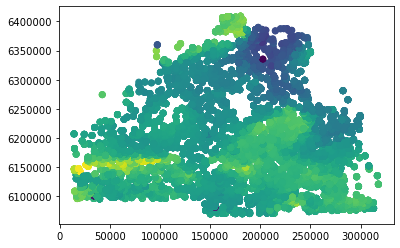

In [87]:
plt.scatter(surface.x, surface.y, c=surface['datum'],)

In [88]:
tops[tops.GL>tops.datum].sort_values(by='GL')

SitID  Formation      MD  Quality                  UWI     DATUM  \
23197  122157      14000   40.84        1  AB/07-11-094-11W4/0   292.000   
23196  122157      13000    3.35        3  AB/07-11-094-11W4/0   292.000   
24190  123982      13000   13.72        3  AA/03-23-096-08W4/0   324.703   
24191  123982      14000  123.14        1  AA/03-23-096-08W4/0   324.703   
23392  122300      13000  143.00        3  AA/07-20-094-14W4/0   429.400   
...       ...        ...     ...      ...                  ...       ...   
17467  114391      10000  451.71        2  00/06-27-083-09W4/0  2465.250   
17468  114391      11000  457.81        3  00/06-27-083-09W4/0  2465.250   
17469  114391      12000  457.81        2  00/06-27-083-09W4/0  2465.250   
17470  114391      13000  457.81        2  00/06-27-083-09W4/0  2465.250   
17471  114391      14000  500.48        1  00/06-27-083-09W4/0  2465.250   

             GL      EREF UNIT     datum      UWI (AGS)     TVDSS  
23197   292.000   292.000    F   89.0016  0944111107AB0   48.1616  
23196   292.000   292.000    F   89.0016  0944111107AB0   85.6516  
24190   329.275   324.703    M  324.7030  0964082303AA0  310.9830  
24191   329.275   324.703    M  324.7030  0964082303AA0  201.5630  
23392   479.400   429.400    M  429.4000  0944142007AA0  286.4000  
...         ...       ...  ...       ...            ...       ...  
17467  2455.750  2465.250    F  751.4082  0834092706000  299.6982  
17468  2455.750  2465.250    F  751.4082  0834092706000  293.5982  
17469  2455.750  2465.250    F  751.4082  0834092706000  293.5982  
17470  2455.750  2465.250    F  751.4082  0834092706000  293.5982  
17471  2455.750  2465.250    F  751.4082  0834092706000  250.9282  

[1096 rows x 12 columns]

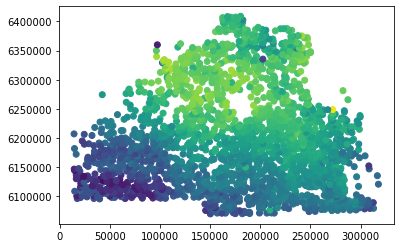

In [89]:
sp = predictions[predictions['Formation'] ==14000]
plt.scatter(sp.x, sp.y, c=sp[0],)

In [31]:
predictions[predictions.SitID ==183527]

SitID  Formation           0             y             x
275660  183527       1000  397.017980  6.136851e+06  48363.583729
275671  183527       2000  490.047984  6.136851e+06  48363.583729
275682  183527       3000  447.312669  6.136851e+06  48363.583729
275693  183527       4000  564.974057  6.136851e+06  48363.583729
275704  183527       5000  578.052114  6.136851e+06  48363.583729
275715  183527       6000  551.848876  6.136851e+06  48363.583729
275726  183527       7000  583.327073  6.136851e+06  48363.583729
275737  183527       9000  587.176239  6.136851e+06  48363.583729
275748  183527       9500  586.838026  6.136851e+06  48363.583729
275759  183527      10000  590.684425  6.136851e+06  48363.583729
275770  183527      11000  595.060440  6.136851e+06  48363.583729
275781  183527      12000  597.120416  6.136851e+06  48363.583729
275792  183527      13000  597.094165  6.136851e+06  48363.583729
275803  183527      14000  616.055008  6.136851e+06  48363.583729

In [28]:
surface

SitID  Formation     SS  Quality                  UWI  DATUM      GL  \
0      102496       1000  321.0        1  00/12-08-067-01W4/0  613.4  609.53   
1      102496       5000  438.0        2  00/12-08-067-01W4/0  613.4  609.53   
2      102496       7000  458.0        3  00/12-08-067-01W4/0  613.4  609.53   
3      102496       9000  468.0        3  00/12-08-067-01W4/0  613.4  609.53   
4      102496       9500  468.0        3  00/12-08-067-01W4/0  613.4  609.53   
...       ...        ...    ...      ...                  ...    ...     ...   
19729  184130      10000  149.0        3  AA/10-30-094-07W4/0  463.6  463.60   
19730  184130      11000  152.0        3  AA/10-30-094-07W4/0  463.6  463.60   
19731  184130      12000  152.0        2  AA/10-30-094-07W4/0  463.6  463.60   
19732  184130      13000  152.0        2  AA/10-30-094-07W4/0  463.6  463.60   
19733  184130      14000  202.0        1  AA/10-30-094-07W4/0  463.6  463.60   

        EREF UNIT  datum      UWI (AGS)   TVDSS             y              x  
0      613.4    M  613.4  0674010812000  317.13  6.079418e+06  312975.247891  
1      613.4    M  613.4  0674010812000  434.13  6.079418e+06  312975.247891  
2      613.4    M  613.4  0674010812000  454.13  6.079418e+06  312975.247891  
3      613.4    M  613.4  0674010812000  464.13  6.079418e+06  312975.247891  
4      613.4    M  613.4  0674010812000  464.13  6.079418e+06  312975.247891  
...      ...  ...    ...            ...     ...           ...            ...  
19729  463.6    M  463.6  0944073010AA0  149.00  6.342270e+06  234609.751965  
19730  463.6    M  463.6  0944073010AA0  152.00  6.342270e+06  234609.751965  
19731  463.6    M  463.6  0944073010AA0  152.00  6.342270e+06  234609.751965  
19732  463.6    M  463.6  0944073010AA0  152.00  6.342270e+06  234609.751965  
19733  463.6    M  463.6  0944073010AA0  202.00  6.342270e+06  234609.751965  

[19734 rows x 14 columns]